In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [87]:
device

'cpu'

# 데이터 분류
> 1. 원본 이미지를 다시 넘버링   
> 2. train/test split하여 파일 분류   
> 3. train/test 각각 다시 넘버링

In [141]:
# 원본 이미지 넘버링하기

import os
import glob

path = 'C:/Users/Administrator'
flood = glob.glob(path+"/flood" + '/*')
not_flood = glob.glob(path+"/not_flood"+'/*')
rainy = glob.glob(path+"/rainy"+'/*')



def rename(files):
#     if 'flood' in files[0]:
#         for i,f in enumerate(files):
#             os.rename(f, os.path.join(path+"/flood", 'flood_' + '{0:03d}.jpg'.format(i)))
#         flood = glob.glob(path+"/flood" + '/*')
#         print("flood {}번째 이미지까지 성공".format(i+1))

#     if 'not_flood' in files[0]:
#         for i,f in enumerate(files):
#             os.rename(f, os.path.join(path+"/not_flood", 'not_flood_' + '{0:03d}.jpg'.format(i)))
#         not_flood = glob.glob(path+"/not_flood"+'/*')
#         print("not_flood {}번째 이미지까지 성공".format(i+1))

    if 'rainy' in files[0]:
        for i,f in enumerate(files):
            os.rename(f, os.path.join(path+"/rainy", 'rainy_' + '{0:03d}.jpg'.format(i)))
        rainy = glob.glob(path+"/rainy"+'/*')
        print("rainy {}번째 이미지까지 성공".format(i+1))

In [106]:
# 이거 이미 완료했는데도 추가 실행하면 이미지가 쓰레기통 행으로 가버림(이유는 모르겠음)
# rename(flood)
# rename(not_flood)
rename(rainy)

rainy 979번째 이미지까지 성공


In [107]:
# 이미지 리스트 정렬
flood = sorted(glob.glob(path+"/flood" + '/*'))
not_flood = sorted(glob.glob(path+"/not_flood"+'/*'))
rainy = sorted(glob.glob(path+"/rainy"+'/*'))

print('flood 이미지 개수: {}\nnot_flood 이미지 개수: {}\nrainy 이미지 개수: {}'.format(len(flood), len(not_flood), len(rainy)))

flood 이미지 개수: 1089
not_flood 이미지 개수: 1004
rainy 이미지 개수: 979


In [108]:
flood_sum = len(flood) + len(not_flood) + len(rainy)

print('전체 이미지 개수 : {}\n\nflood 이미지 비율 : {:.2f}%\nnot_flood 이미지 비율 : {:.2f}\nrainy 이미지 비율 : {:.2f}'.format( flood_sum, 100*len(flood)/flood_sum, 100*len(not_flood)/flood_sum, 100*len(rainy)/flood_sum))

전체 이미지 개수 : 3072

flood 이미지 비율 : 35.45%
not_flood 이미지 비율 : 32.68
rainy 이미지 비율 : 31.87


#### 아주 약간 데이터가 imbalance하지만 이 정도는 크게 문제가 없어보임. 아마 fine tuning이 관건일 것 같음

# 정리한 이미지 시각화하기

In [109]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
%matplotlib inline

In [110]:
# cv2를 이용해 이미지를 읽는 함수 정의
def read_img(file_path):
    img_arr = cv2.imread(file_path)
    return cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB) # cvtColor로 BGR을 RGB로 바꿔줌

In [111]:
# 각 이미지 폴더에서 3개씩 랜덤으로 이미지 시각화 하기

# 이미지 array 준비
import random
img_arrs = []
img_num = range(0,300)

for i in random.sample(img_num,3):
    
    img_arrs.append(read_img(flood[i]))
    img_arrs.append(read_img(not_flood[i]))
    img_arrs.append(read_img(rainy[i]))


In [112]:
print("총 {}개의 이미지 ".format(len(img_arrs)))

총 9개의 이미지 


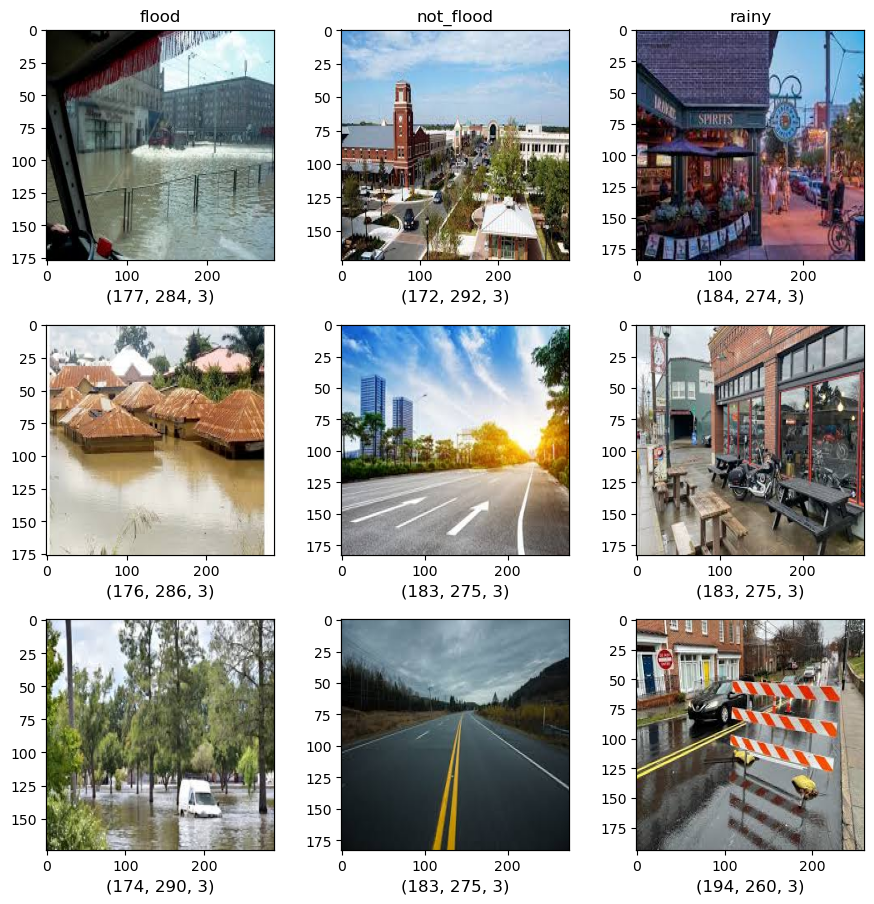

In [113]:
rows = 3 # 3개씩 샘플링 했으므로
columns = 3

# 그림판 설정
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))

# 각 판에 이미지 출력
for num in range(1, rows*columns+1): # 1번 부터 15번 까지
    
    fig.add_subplot(rows, columns, num) # 원하는 위치 번호(num)를 입력
    idx = num - 1 # 인덱스
    
    plt.imshow(img_arrs[idx], aspect='auto')
    plt.xlabel(f'{img_arrs[idx].shape}', fontsize=12)

fig.tight_layout() # 이미지 사이 간격 조정



# 제목 설정
cols = ['flood', 'not_flood', 'rainy']

for folder_idx, ax in enumerate(axes[0]):
    ax.set_title(cols[folder_idx])

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

#### 역시 이미지들의 사이즈가 전부 다름.

# train/test split하기
> 데이터양이 적으므로 8:2 비율로 split   
> 사이킷런 같은 모듈로 나누는게 아니라 train/test 파일에 이미지를 복사해서 새 파일을 만들어야 한다.   
> 이미지를 8:2 비율로 랜덤으로 train/test에 파일을 복사하여 파일을 만들자.   

In [114]:
path = "C:/Users/Administrator"
flood = sorted(glob.glob(path+"/flood" + '/*'))
not_flood = sorted(glob.glob(path+"/not_flood"+'/*'))
rainy = sorted(glob.glob(path+"/rainy"+'/*'))

print('flood 이미지 개수: {}\nnot_flood 이미지 개수: {}\nrainy 이미지 개수: {}'.format(len(flood), len(not_flood), len(rainy)))

flood 이미지 개수: 1089
not_flood 이미지 개수: 1004
rainy 이미지 개수: 979


In [115]:
# 비율이 작은 test로 빠르게 split

import math

flood_test_count = round(len(flood)*0.2)
not_flood_test_count = round(len(not_flood)*0.2)
rainy_test_count = round(len(rainy)*0.2)

print('flood_test파일에 들어갈 이미지 개수 : {}/{}'.format(flood_test_count,len(flood)))
print('not_flood_test파일에 들어갈 이미지 개수 : {}/{}'.format(not_flood_test_count,len(not_flood)))
print('rainy_test파일에 들어갈 이미지 개수 : {}/{}'.format(rainy_test_count,len(rainy)))

flood_test파일에 들어갈 이미지 개수 : 218/1089
not_flood_test파일에 들어갈 이미지 개수 : 201/1004
rainy_test파일에 들어갈 이미지 개수 : 196/979


In [116]:
import shutil
def split( img_list, test_count, train_path, test_path):
  
    test_files=[]
    for i in random.sample( img_list, test_count ):
        test_files.append(i)

    # 차집합으로 train/test 리스트 생성하기
    train_files = [x for x in img_list if x not in test_files]

    for k in train_files:
        shutil.copy(k, train_path)
  
    for c in test_files:
        shutil.copy(c, test_path)

    print('train 폴더 이미지 개수 : {}\ntest 폴더 이미지 개수 : {}'.format(len(glob.glob(train_path+'/*')),len(glob.glob(test_path+'/*'))))

In [117]:
# 돌고래 파일
flood_train_path='C:/Users/Administrator/Project/train/flood'
flood_test_path='C:/Users/Administrator/Project/test/flood'

not_flood_train_path='C:/Users/Administrator/Project/train/not_flood'
not_flood_test_path='C:/Users/Administrator/Project/test/not_flood'

rainy_train_path='C:/Users/Administrator/Project/train/rainy'
rainy_test_path='C:/Users/Administrator/Project/test/rainy'

split(flood, flood_test_count, flood_train_path, flood_test_path)
split(not_flood, not_flood_test_count, not_flood_train_path, not_flood_test_path)
split(rainy, rainy_test_count, rainy_train_path, rainy_test_path)

train 폴더 이미지 개수 : 871
test 폴더 이미지 개수 : 218
train 폴더 이미지 개수 : 803
test 폴더 이미지 개수 : 201
train 폴더 이미지 개수 : 783
test 폴더 이미지 개수 : 196


#### 약 한 7분 정도 소요됨. 아마 넘파이 형태로 진행하면 훨씬 시간이 적게 걸릴 것임(폴더를 정리해야하기 때문에 이미지째로 진행)

# train/test로 split한 이미지들은 랜덤 추출했기 때문에 다시 넘버링 해주자.

In [129]:
# 원본 이미지 넘버링하기 -> rename 함수를 만들어줬으므로 경로만 바꿔서 재사용

# trainset 넘버링

path = "C:/Users/Administrator/Project/train"
flood = glob.glob(path+"/flood" + '/*')
not_flood = glob.glob(path+"/not_flood"+'/*')
rainy = glob.glob(path+"/rainy"+'/*')

# rename(flood)
# rename(not_flood)
rename(rainy)

rainy 783번째 이미지까지 성공


In [130]:
path = "C:/Users/Administrator/Project/train"
flood = glob.glob(path+"/flood" + '/*')
not_flood = glob.glob(path+"/not_flood"+'/*')
rainy = glob.glob(path+"/rainy"+'/*')

print('각각 마지막 파일 이름 : ',os.path.basename(sorted(flood)[-1]), os.path.basename(sorted(not_flood)[-1]), os.path.basename(sorted(rainy)[-1]))

각각 마지막 파일 이름 :  flood_870.jpg not_flood_802.jpg rainy_782.jpg


In [142]:
# testset 넘버링

path = "C:/Users/Administrator/Project/test"
flood = glob.glob(path+"/flood" + '/*')
not_flood = glob.glob(path+"/not_flood"+'/*')
rainy = glob.glob(path+"/rainy"+'/*')

# rename(flood)
# rename(not_flood)
rename(rainy)

rainy 196번째 이미지까지 성공


In [143]:
path = "C:/Users/Administrator/Project/test"
flood = glob.glob(path+"/flood" + '/*')
not_flood = glob.glob(path+"/not_flood"+'/*')
rainy = glob.glob(path+"/rainy"+'/*')

print('각각 마지막 파일 이름 : ',os.path.basename(sorted(flood)[-1]), os.path.basename(sorted(not_flood)[-1]), os.path.basename(sorted(rainy)[-1]))

각각 마지막 파일 이름 :  flood_217.jpg not_flood_200.jpg rainy_195.jpg
